## BIAS VARIANCE EXAMPLE 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.utils import resample
from tqdm import tqdm

## Synthetic data 

In [2]:
X, y = make_moons(n_samples=500, noise=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=7, stratify=y
)

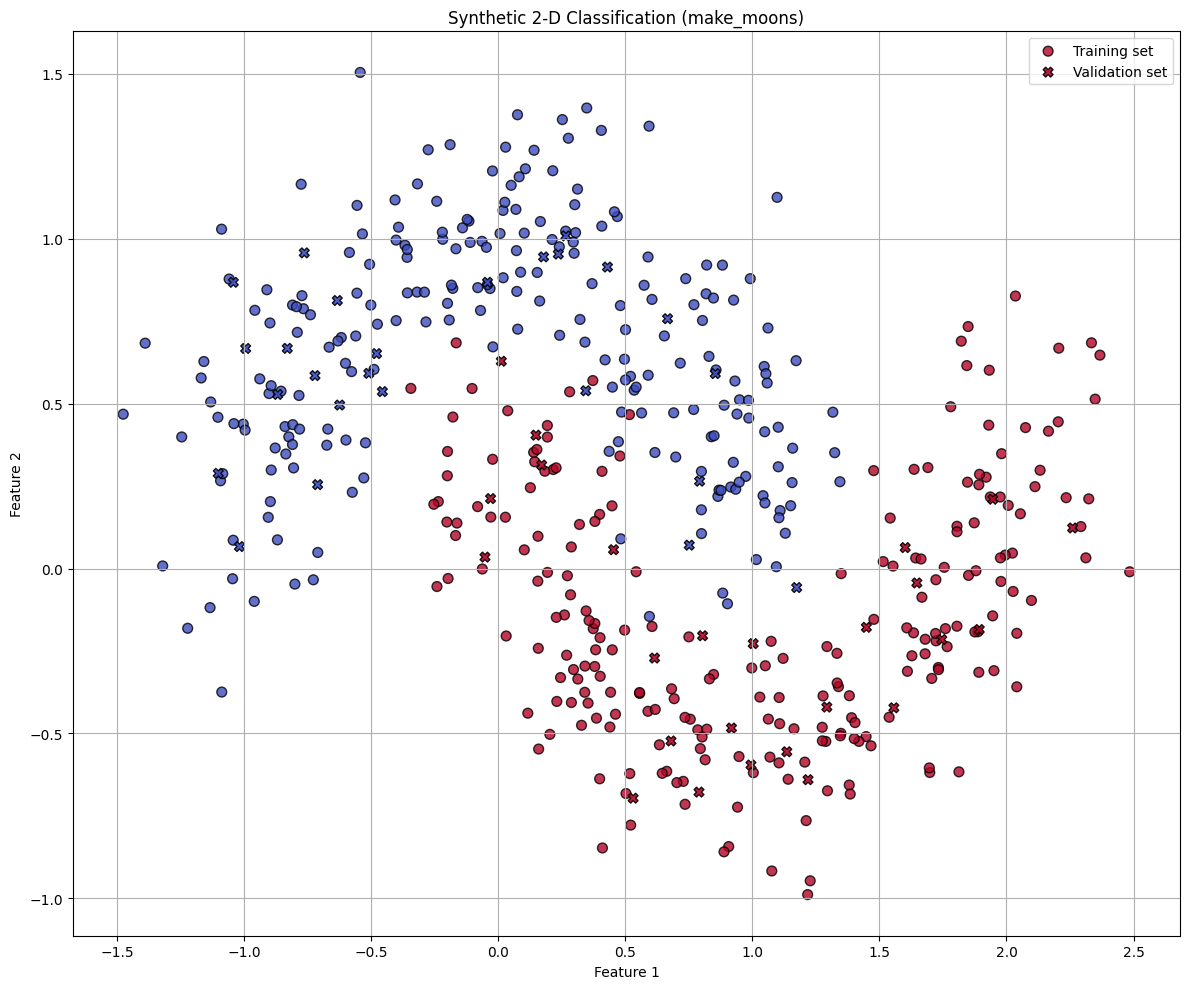

In [3]:
plt.figure(figsize=(12, 10))

# Training set (blue circles)
plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=y_train,
    cmap="coolwarm",
    s=50,
    alpha=0.8,
    edgecolor="k",
    label="Training set",
)

# Validation set (green crosses)
plt.scatter(
    X_val[:, 0],
    X_val[:, 1],
    c=y_val,
    cmap="coolwarm",
    marker="X",
    s=50,
    alpha=0.9,
    edgecolor="k",
    label="Validation set",
)

plt.title("Synthetic 2‑D Classification (make_moons)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Helper function: train a logistic regression with polynomial features

### Polynomial Features with scikit‑learn

`PolynomialFeatures` is a convenient tool for creating a new feature matrix that contains all polynomial combinations of the original features up to a specified degree.  
It is commonly used to give a linear model (e.g., linear regression, logistic regression, SVM, etc.) the ability to capture non‑linear relationships without having to hand‑craft the new features yourself.

## Definition

+ Given an input matrix $X$ of shape $(n_{samples}, n_{features})$, it returns a new matrix $X_{poly}$ of shape $(n_{samples}, n_{output})$ where: $X_{poly}[:, i] = \prod_{j=1}^k x_j ^{a_j} $ for all multi‑indices $(a_0, a_1, …, a_{i-1})$ such that $0 ≤ a_j ≤ degree$ and $\sum_{j=0}^i a_j = degree$ and with $i > $ the original feature indices.  
+ If interaction_only=True, the constraint $a_j \in {0,1}$ is added, so only cross‑terms (no squares or higher powers of a single feature) are generated.

In [4]:
def train_poly_lr(degree, C=1.0):
    """
    Train LogisticRegression on polynomial features of given degree.
    """
    poly = PolynomialFeatures(degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    clf = LogisticRegression(
        penalty="l2",
        C=C,
        solver="lbfgs",
        max_iter=2000,
        random_state=0,
    )
    clf.fit(X_train_poly, y_train)

    # Store transformer to reuse for predictions, the flexibility of objects in python
    clf.poly = poly
    return clf

### Iterate over the different degrees

In [5]:
max_degree = 25
degrees = list(range(1, max_degree + 1))

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for d in degrees:
    clf = train_poly_lr(d, C=1.0)

    X_train_poly = clf.poly.transform(X_train)
    X_val_poly = clf.poly.transform(X_val)

    # Probabilities for log‑loss (cross‑entropy)
    train_proba = clf.predict_proba(X_train_poly)
    val_proba = clf.predict_proba(X_val_poly)

    # Training & validation log‑loss
    train_losses.append(log_loss(y_train, train_proba))
    val_losses.append(log_loss(y_val, val_proba))

    # Accuracy
    train_accuracies.append(accuracy_score(y_train, clf.predict(X_train_poly)))
    val_accuracies.append(accuracy_score(y_val, clf.predict(X_val_poly)))

<span style="background-color: #FFFF99;">--------------------------------------------------------------------------------------------------------------------------------</span>

#  Bootstrap bias/variance estimation 

## Bootstrap bias/variance estimation is a **resampling technique** used in statistics to quantify the uncertainty and performance of an estimator or model.

### + Estimate Variance: The variance of the estimator can then be estimated by calculating the sample variance of these \(B\) bootstrap estimates.

### + Calculate Estimator on Each Sample

In [6]:
n_boot = 50
bootstrap_b2 = []
bootstrap_variance = []

# use a held‑out test set (same as validation set in this demo)
X_test = X_val
y_test = y_val

for d in tqdm(degrees, desc="Bootstrap bias/var"):
    # Train on each bootstrap sample and collect predictions
    probs_boot = np.zeros((n_boot, X_test.shape[0]))

    for i in range(n_boot):
        Xb, yb = resample(
            X_train, y_train, replace=True, n_samples=len(X_train), random_state=i
        )
        poly = PolynomialFeatures(d, include_bias=False)
        Xb_poly = poly.fit_transform(Xb)
        Xtest_poly = poly.transform(X_test)

        clf_b = LogisticRegression(
            penalty="l2",
            C=1.0,
            solver="lbfgs",
            max_iter=1000,
            random_state=0,
        )
        clf_b.fit(Xb_poly, yb)
        probs_boot[i] = clf_b.predict_proba(Xtest_poly)[:, 1]  # probability of class 1

    # Mean predicted probability over bootstrap models
    probs_mean = probs_boot.mean(axis=0)

    # Bias^2: squared difference between mean predictions and true labels
    b2 = np.mean((probs_mean - y_test) ** 2)
    bootstrap_b2.append(b2)

    # Variance: variance of predictions across bootstrap models
    var = np.mean(np.var(probs_boot, axis=0))
    bootstrap_variance.append(var)

Bootstrap bias/var: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:28<00:00,  1.13s/it]


# Plotting

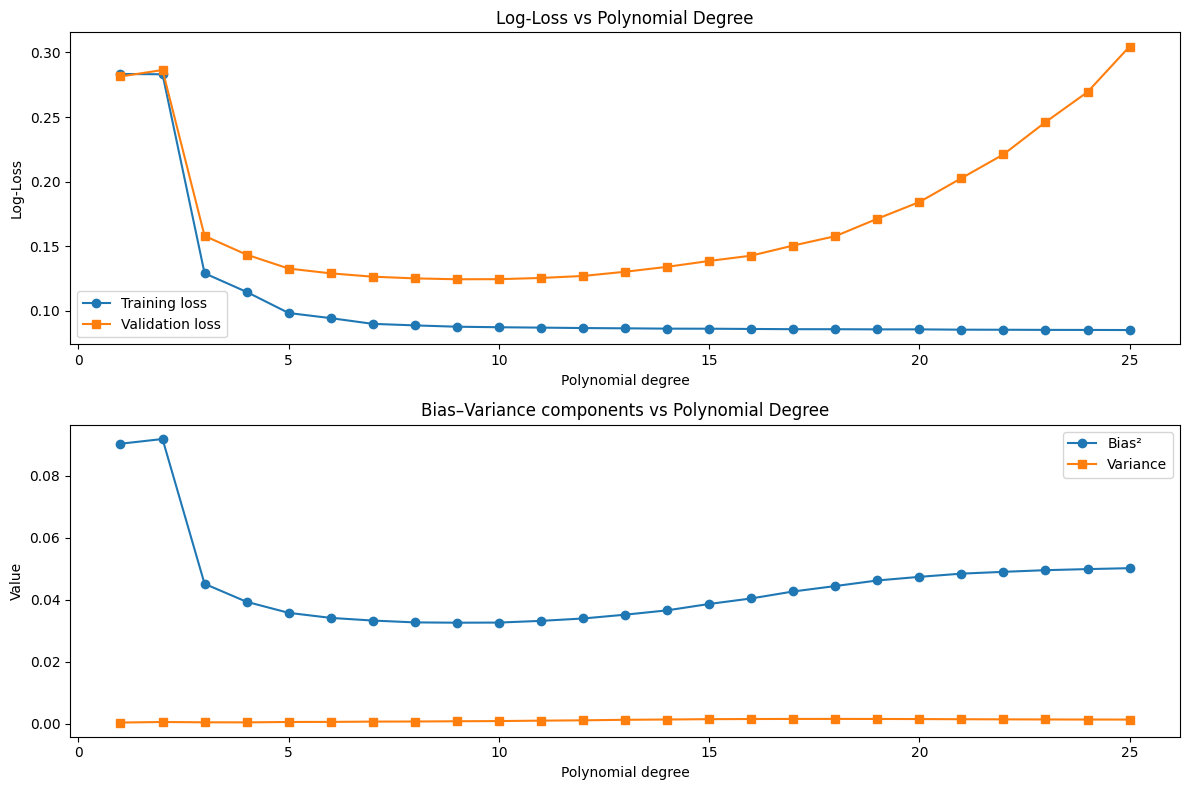

In [7]:
plt.figure(figsize=(12, 8))

# a) Train / Validation error
plt.subplot(2, 1, 1)
plt.plot(degrees, train_losses, "o-", label="Training loss")
plt.plot(degrees, val_losses, "s-", label="Validation loss")
plt.title("Log‑Loss vs Polynomial Degree")
plt.xlabel("Polynomial degree")
plt.ylabel("Log‑Loss")
plt.legend()

# b) Bias^2 + Variance
plt.subplot(2, 1, 2)
plt.plot(degrees, bootstrap_b2, "o-", label="Bias²")
plt.plot(degrees, bootstrap_variance, "s-", label="Variance")
plt.title("Bias–Variance components vs Polynomial Degree")
plt.xlabel("Polynomial degree")
plt.ylabel("Value")
plt.legend()

plt.tight_layout()
plt.show()

<span style="background-color: #FFFF99;">--------------------------------------------------------------------------------------------------------------------------------</span>

## BIAS VARIANCE EXAMPLE 2

### Bias and Variance

+ **Bias** refers to the error due to overly simplistic assumptions in the learning algorithm.
    - High bias models tend to underfit the data.
    - Example: trying to use linear models on highly non-linear data.

+ **Variance** refers to the model's sensitivity to fluctuations in the training data.
    - High variance models tend to overfit the training data and perform poorly on unseen data.
    - Example: Very deep decision trees memorizing noise.

The goal is to **find a balance** between bias and variance for better generalization.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for machine learning utilities
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

### Dataset: intentionally harder and with fewer samples

In [9]:
X, y = make_classification(
    n_samples=150,  # smaller sample size to provoke overfitting
    n_features=10,
    n_informative=5,
    n_redundant=2,
    flip_y=0.15,  # introduce label noise
    class_sep=0.5,  # less separation between classes
    random_state=0,
)

# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# Simple model: high bias
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# extract predictions
y_pred_lr = logreg.predict(X_test)

# Complex model: high variance
deep_tree = DecisionTreeClassifier(max_depth=None, random_state=0)
deep_tree.fit(X_train, y_train)


# Accuracy on train and test sets
def print_acc(model, name):
    acc_train = model.score(X_train, y_train)
    acc_test = model.score(X_test, y_test)
    print(f"{name}\nTrain Acc: {acc_train:.2f} | Test Acc: {acc_test:.2f}\n")


print_acc(logreg, "Logistic Regression (High Bias)")
print_acc(deep_tree, "Deep Decision Tree (High Variance)")

Logistic Regression (High Bias)
Train Acc: 0.60 | Test Acc: 0.53

Deep Decision Tree (High Variance)
Train Acc: 1.00 | Test Acc: 0.60



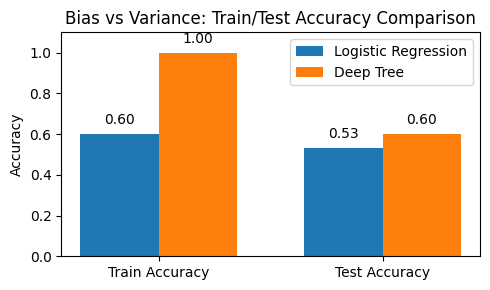

In [10]:

# Get accuracy scores
logreg_train_acc = logreg.score(X_train, y_train)
logreg_test_acc = logreg.score(X_test, y_test)

tree_train_acc = deep_tree.score(X_train, y_train)
tree_test_acc = deep_tree.score(X_test, y_test)

# Bar chart for comparison
labels = ["Train Accuracy", "Test Accuracy"]
logreg_scores = [logreg_train_acc, logreg_test_acc]
tree_scores = [tree_train_acc, tree_test_acc]

x = np.arange(len(labels))  # the label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(5, 3)) #plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width / 2, logreg_scores, width, label="Logistic Regression")
bars2 = ax.bar(x + width / 2, tree_scores, width, label="Deep Tree")

# Labels and formatting
ax.set_ylabel("Accuracy")
ax.set_title("Bias vs Variance: Train/Test Accuracy Comparison")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.1)
ax.legend()

# Annotate each bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f"{height:.2f}",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 5),  # offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )

plt.tight_layout()
plt.show()

<span style="background-color: #FFFF99;">--------------------------------------------------------------------------------------------------------------------------------</span>

# The $p\text{-}value$

### What Is a $p\text{-}value$?
In hypothesis testing the $p\text{-}value$ is a probability that quantifies how extreme your observed data are under the null hypothesis ($H_0$).

+ $p\text{-}value$ = probability of observing your data (or more extreme) assuming $H_0$ is true.

### How is p-value used?

+ if $p\text{-}value \leq \alpha $ reject $H_0$
+ if $p\text{-}value > \alpha $ do not reject $H_0$

### Problems with $p\text{-}value$

+ A small $p\text{-}value$ does not mean the effect is large or practically important.
+ A large $p\text{-}value$ does not prove $H_0$ is true—just that the data did not provide enough evidence to reject it.

<span style="background-color: #FFFF99;">--------------------------------------------------------------------------------------------------------------------------------</span>

# Example Are Male and Female Salaries Different?

### The Question
+ Null hypothesis ($H_0$ ): The average salary of men equals the average salary of women.
+ Alternative hypothesis ($H_1$): The average salaries differ (two‑tailed). 

In [11]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------
# 1.1  Read the CSV
# -------------------------------------------------
df = pd.read_csv("data/salary_data.csv")  # <-- change file name / path

# -------------------------------------------------
# 1.2  Inspect the first rows
# -------------------------------------------------
print(df.head())
print(df.columns)  # show column names
print(df.dtypes)

    Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0  
Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Salary'],
      dtype='object')
Age                    float64
Gender                  object
Education Level         object
Job Title               object
Years of Experience    float64
Salary                 float64
dtype: object


In [12]:
# 2.1  Keep only relevant columns
df = df[["Gender", "Salary"]].copy()

# 2.2  Drop rows with missing salaries or genders
df.dropna(subset=["Gender", "Salary"], inplace=True)

In [13]:
# 2.3  Make sure gender values are consistent
df["Gender"] = df["Gender"].str.strip().str.title()  # 'male' → 'Male'

# 2.4  Verify gender distribution
print(df["Gender"].value_counts())

# 2.5  Check salary range (just to spot obvious outliers)
print(df["Salary"].describe())

Gender
Male      3672
Female    3013
Other       14
Name: count, dtype: int64
count      6699.000000
mean     115326.964771
std       52786.183911
min         350.000000
25%       70000.000000
50%      115000.000000
75%      160000.000000
max      250000.000000
Name: Salary, dtype: float64


# Box‑plots / Violin‑plots

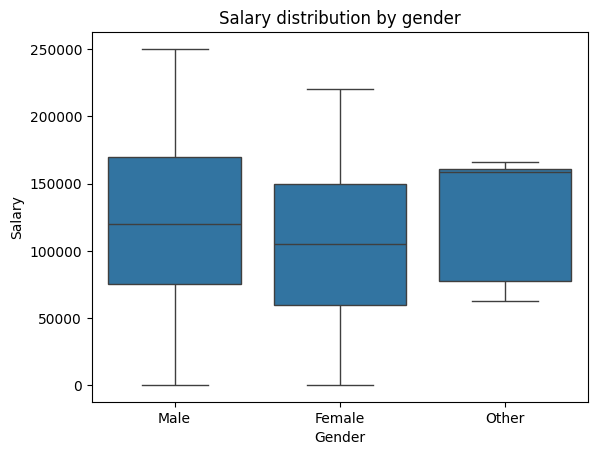

In [14]:
sns.boxplot(x="Gender", y="Salary", data=df)
plt.title("Salary distribution by gender")
plt.show()

# Normality Test (Shapiro–Wilk)

In [15]:
male = df[df["Gender"] == "Male"]["Salary"].values
female = df[df["Gender"] == "Female"]["Salary"].values

print("Male normality p‑value:", st.shapiro(male).pvalue)
print("Female normality p‑value:", st.shapiro(female).pvalue)

Male normality p‑value: 4.947423192085343e-32
Female normality p‑value: 4.190125281939249e-29


## Nope no normality, we need to use use a non‑parametric test (Mann–Whitney U)

In [16]:
u_stat, p_value_mw = st.mannwhitneyu(male, female, alternative="two-sided")

print(f"U‑statistic = {u_stat:.0f}, p‑value = {p_value_mw:.20f}")

U‑statistic = 6339556, p‑value = 0.00000000000000000000


### We reject $H_0$ with all the caveats mentioned before

# Statistical Test Demo
Showing α (Type I) and β (Type II) Errors in Practice

+ Generates two normally‑distributed populations
+ Performs a two‑sample t‑test
+ Shows how the chosen significance level α controls the false‑positive rate
+ Estimates the β (false‑negative) rate by repeated simulation (i.e. the power of the test)



In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Statistical Test Demo – α (Type‑I) & β (Type‑II) Errors

+ Samples are coming $N(0, 1)$ vs $N(\delta, 1)$
+ **Test:** two‑sample t‑test (different means, equal variances)
+ **α = 0.05**  *(pre‑chosen significance level)*
+ **β** is estimated by Monte‑Carlo simulation:  
  + count how often we _fail_ to reject $H_0$ when it is false  
    *(power = 1 – β)*

The script plots:


+ The empirical α (false‑positive) vs β (false‑negative) for various sample sizes

<figure>
  <img src="Images/types.svg" alt="Errors" style="width: 400px; max-width: 100%; height: auto;">
  <figcaption>Figure 1: Errors</figcaption>
</figure>

<span style="background-color: #FFFF99;">--------------------------------------------------------------------------------------------------------------------------------</span>

# Helper: run a single two‑sample t‑test and return p‑value
## A t-test is a statistical test used to compare the means of two groups/classes and determine if there's a statistically significant difference between them. 

In [18]:
def two_sample_t_test(x, y):
    """Return the two‑sided p‑value from an independent t‑test."""
    t_stat, p_val = stats.ttest_ind(x, y, equal_var=True)
    return p_val

# Parameters

In [19]:
alpha = 0.05  # chosen significance level
delta = 2.0  # true mean difference (effect size)
sigma = 1.0  # common standard deviation
n_reps = 10000  # number of simulation repetitions
sample_sizes = [10, 20, 30, 50, 80, 120]  # sample size per group

# Simulate a Monte Carlo Estimation of empirical alpha (Type I error)

### alpha is the probability of rejecting a true null hypothesis $H_0$

## The classes are identical 

In [20]:
emp_alpha = []
for n in sample_sizes:
    rejects = 0
    for _ in range(n_reps):
        # Identical Classes
        group1 = np.random.normal(loc=0, scale=sigma, size=n)
        group2 = np.random.normal(loc=0, scale=sigma, size=n)
        p = two_sample_t_test(group1, group2)
        if p < alpha:
            rejects += 1
    emp_alpha.append(rejects / n_reps)

# Simulate a Monte Carlo Estimation of empirical beta (Type II error)

### power is defined as the probability of correctly rejecting a false null hypothesis $H_0$

$$Power = 1 - \beta$$

In [21]:
emp_beta = []
emp_power = []
for n in sample_sizes:
    fails = 0  # fail to reject when H0 is false
    for _ in range(n_reps):
        group1 = np.random.normal(loc=0, scale=sigma, size=n)
        group2 = np.random.normal(loc=delta, scale=sigma, size=n)
        p = two_sample_t_test(group1, group2)
        if p >= alpha:  # we *fail* to reject H0
            fails += 1
    beta = fails / n_reps
    power = 1 - beta
    emp_beta.append(beta)
    emp_power.append(power)

# Visualise the results

### The distributions for a single run  

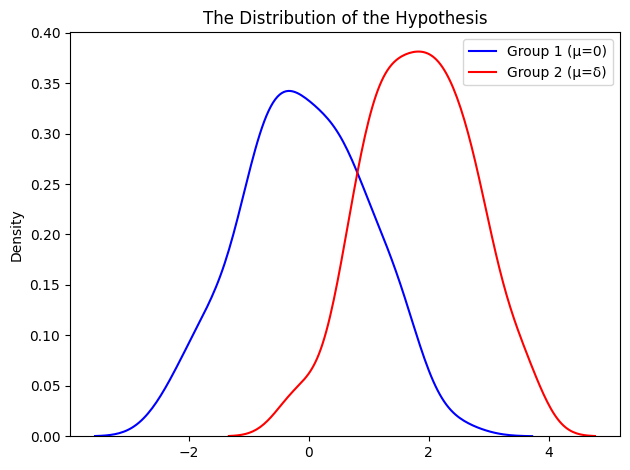

In [22]:
n_samples = 100
g1 = np.random.normal(loc=0, scale=sigma, size=n_samples)
g2 = np.random.normal(loc=delta, scale=sigma, size=n_samples)

sns.kdeplot(g1, label="Group 1 (μ=0)", color="blue")
sns.kdeplot(g2, label="Group 2 (μ=δ)", color="red")
plt.title(f"The Distribution of the Hypothesis")
plt.legend()
plt.tight_layout()
plt.show()

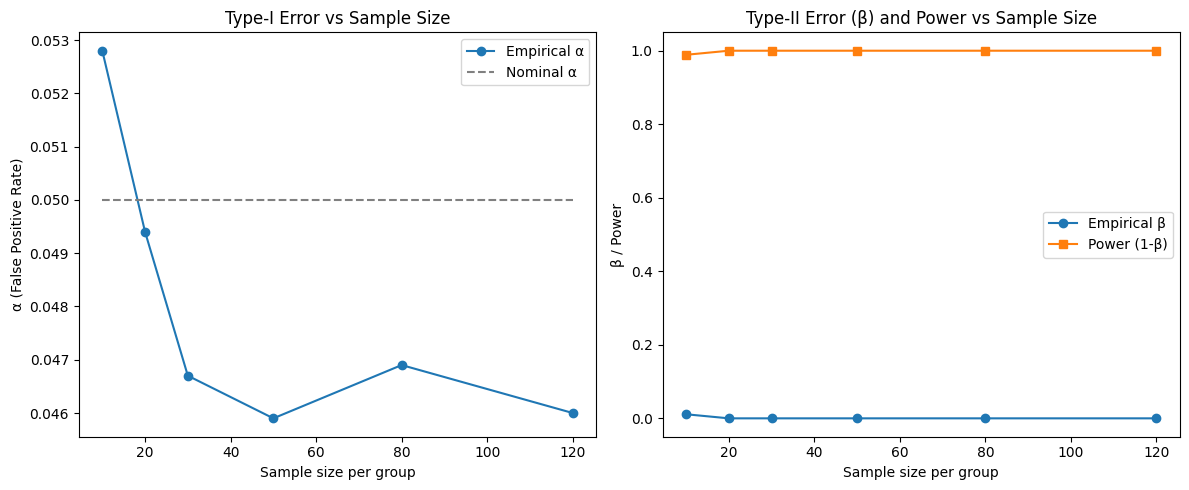

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(sample_sizes, emp_alpha, "o-", label="Empirical α")
plt.hlines(
    alpha,
    xmin=sample_sizes[0],
    xmax=sample_sizes[-1],
    colors="gray",
    linestyles="dashed",
    label="Nominal α",
)
plt.xlabel("Sample size per group")
plt.ylabel("α (False Positive Rate)")
plt.title("Type‑I Error vs Sample Size")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sample_sizes, emp_beta, "o-", label="Empirical β")
plt.plot(sample_sizes, emp_power, "s-", label="Power (1-β)")
plt.xlabel("Sample size per group")
plt.ylabel("β / Power")
plt.title("Type‑II Error (β) and Power vs Sample Size")
plt.legend()

plt.tight_layout()
plt.show()

<span style="background-color: #FFFF99;">--------------------------------------------------------------------------------------------------------------------------------</span>

Confusion matrix 
===

A **confusion matrix** is a simple and intuitive tool to summarize prediction results for classification problems.

|                 | Predicted Positive | Predicted Negative |
|-----------------|--------------------|--------------------|
| **Actual Positive** | True Positive (TP)     | False Negative (FN)    |
| **Actual Negative** | False Positive (FP)    | True Negative (TN)     |

From this, we derive the following metrics:

- **Accuracy** = (TP + TN) / Total
- **Precision** = TP / (TP + FP) : How many predicted positives are truly positive?
- **Recall (Sensitivity)** = TP / (TP + FN) : How many actual positives were detected?
- **F1 Score** = 2 × (Precision × Recall) / (Precision + Recall) : Harmonic mean of precision and recall

These metrics are especially useful when the data is **imbalanced**.

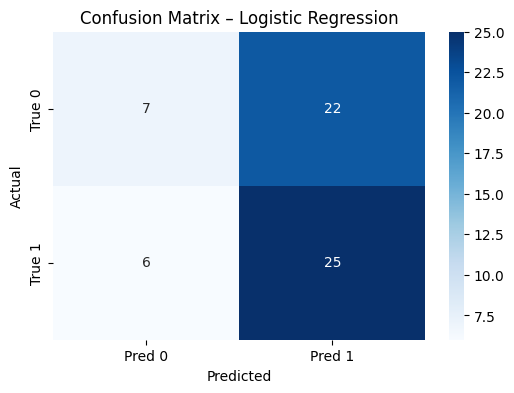

In [24]:
# Confusion matrix for Logistic Regression
cm = confusion_matrix(y_test, y_pred_lr)

# Display with seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

In [25]:
cm

array([[ 7, 22],
       [ 6, 25]])

In [26]:
# Print classification report
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))

# Extract individual metrics
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)

print(f"Recall (Sensitivity): {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.54      0.24      0.33        29
           1       0.53      0.81      0.64        31

    accuracy                           0.53        60
   macro avg       0.54      0.52      0.49        60
weighted avg       0.54      0.53      0.49        60

Recall (Sensitivity): 0.81
F1 Score: 0.64


<span style="background-color: #FFFF99;">--------------------------------------------------------------------------------------------------------------------------------</span>

# The Multi Class case using Micro Averages

In [27]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

# Helper to pretty‑print a dict of metrics

In [28]:
def print_metrics(name, y_true, y_pred, avg="micro"):
    print(f"\n{name} (average={avg}):")
    print(f"  Precision: {precision_score(y_true, y_pred, average=avg):.4f}")
    print(f"  Recall:    {recall_score(y_true, y_pred, average=avg):.4f}")
    print(f"  F1:        {f1_score(y_true, y_pred, average=avg):.4f}")
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nFull classification report:")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))

# Generate a toy imbalanced multi‑class data set

In [29]:
# 3 classes, 2000 samples, heavily imbalanced
X, y = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=12,
    n_redundant=5,
    n_classes=3,
    n_clusters_per_class=1,
    weights=[0.7, 0.25, 0.05],  # 70% class 0, 25% class 1, 5% class 2
    flip_y=0.01,
    random_state=42,
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Train logistic regression with class_weight='balanced'

In [30]:
clf = LogisticRegression(
    solver="lbfgs", max_iter=1000, class_weight="balanced", random_state=42
)
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


# Micro-averaged metrics

In [31]:
y_pred = clf.predict(X_test)

# Step 5: Micro-averaged metrics
precision_micro = precision_score(y_test, y_pred, average="micro")
recall_micro = recall_score(y_test, y_pred, average="micro")
f1_micro = f1_score(y_test, y_pred, average="micro")

In [32]:
precision_micro = precision_score(y_test, y_pred, average="micro")
recall_micro = recall_score(y_test, y_pred, average="micro")
f1_micro = f1_score(y_test, y_pred, average="micro")

print("=== Micro-Averaged Metrics ===")
print(f"Precision (micro): {precision_micro:.4f}")
print(f"Recall (micro):    {recall_micro:.4f}")
print(f"F1 Score (micro):  {f1_micro:.4f}")

=== Micro-Averaged Metrics ===
Precision (micro): 0.9167
Recall (micro):    0.9167
F1 Score (micro):  0.9167


# Macro-averaged for comparison

In [33]:
precision_macro = precision_score(y_test, y_pred, average="macro")
recall_macro = recall_score(y_test, y_pred, average="macro")
f1_macro = f1_score(y_test, y_pred, average="macro")

print("\n=== Macro-Averaged Metrics (for comparison) ===")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro):    {recall_macro:.4f}")
print(f"F1 Score (macro):  {f1_macro:.4f}")


=== Macro-Averaged Metrics (for comparison) ===
Precision (macro): 0.7878
Recall (macro):    0.8919
F1 Score (macro):  0.8216


# Another Example of Micro and Macro Average

##  Create a toy dataset

In [34]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
                             precision_recall_fscore_support,
                             classification_report)

# 5‑class classification, 1500 samples
X, y = make_classification(n_samples=1500,
                           n_features=20,
                           n_informative=10,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=5,
                           n_clusters_per_class=1,
                           weights=[0.4, 0.2, 0.1, 0.1, 0.2],   # imbalanced
                           flip_y=0.01,
                           random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

## Get the confusion matrix

In [35]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[166   1   1   0  12]
 [  3  75   2   2   8]
 [  6   1  33   0   5]
 [  3   6   1  27   8]
 [ 16   6   4   1  63]]


In [36]:
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, labels=[0,1,2,3,4], zero_division=0)

df = pd.DataFrame({'class': [0,1,2,3,4],
                   'precision': precision,
                   'recall': recall,
                   'f1-score': f1,
                   'support': support})
print(df)

   class  precision    recall  f1-score  support
0      0   0.855670  0.922222  0.887701      180
1      1   0.842697  0.833333  0.837989       90
2      2   0.804878  0.733333  0.767442       45
3      3   0.900000  0.600000  0.720000       45
4      4   0.656250  0.700000  0.677419       90


In [37]:
precision

array([0.8556701 , 0.84269663, 0.80487805, 0.9       , 0.65625   ])

# Full classification report

In [36]:
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))


=== Classification Report ===
              precision    recall  f1-score   support

           0     0.8557    0.9222    0.8877       180
           1     0.8427    0.8333    0.8380        90
           2     0.8049    0.7333    0.7674        45
           3     0.9000    0.6000    0.7200        45
           4     0.6562    0.7000    0.6774        90

    accuracy                         0.8089       450
   macro avg     0.8119    0.7578    0.7781       450
weighted avg     0.8125    0.8089    0.8069       450



## Per‑class “micro‑average” (binary) metrics – manual

In [38]:
classes = np.unique(y_test)          # [0, 1, 2, 3, 4]
per_class_metrics = {}

for cls in classes:
    # Treat `cls` as positive, everything else negative
    tp  = cm[cls, cls]                           # true positives for this class
    fp  = cm[:, cls].sum() - tp                  # false positives
    fn  = cm[cls, :].sum() - tp                  # false negatives

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    per_class_metrics[cls] = (precision, recall, f1)

print("\nPer‑class micro‑average (binary) metrics – manual:")
for cls, (p, r, f) in per_class_metrics.items():
    print(f"  Class {cls:1d} →  precision={p:.3f}  recall={r:.3f}  f1={f:.3f}")


Per‑class micro‑average (binary) metrics – manual:
  Class 0 →  precision=0.856  recall=0.922  f1=0.888
  Class 1 →  precision=0.843  recall=0.833  f1=0.838
  Class 2 →  precision=0.805  recall=0.733  f1=0.767
  Class 3 →  precision=0.900  recall=0.600  f1=0.720
  Class 4 →  precision=0.656  recall=0.700  f1=0.677


<span style="background-color: #FFFF99;">--------------------------------------------------------------------------------------------------------------------------------</span>

# Precision in Computer Vision IoU

In [39]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

# IoU the bounding box

In [40]:
def iou(boxA, boxB):
    """
    boxA, boxB: (x1, y1, x2, y2) – float tensors (or numpy arrays)
    returns: float IoU
    """
    # intersection
    inter_top_left = torch.max(boxA[:2], boxB[:2])
    inter_bot_right = torch.min(boxA[2:], boxB[2:])
    inter_wh = (inter_bot_right - inter_top_left).clamp(
        min=0
    )  # Basically you can define a min or max
    inter_area = inter_wh[0] * inter_wh[1]

    # union
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = areaA + areaB - inter_area

    return inter_area / union

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet‑50 + FPN trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device).eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [42]:
device

device(type='cpu')

# Load a single Image

In [43]:
img_path = "data/coco_images/istockphoto-962596556-612x612_jpg.rf.673a1eabc051e188df003634594b862b.jpg"

In [44]:
ann_path = "data/coco_images/_annotations.coco.json"

In [45]:
img = torchvision.io.read_image(img_path).to(device)

In [46]:
tran = T.Compose([T.ToTensor()])
img = tran(img.numpy())

In [47]:
img.shape

torch.Size([640, 3, 640])

In [48]:
img_np = img.permute(2, 0, 1).cpu().numpy()
img_model = img.permute(1, 2, 0).cpu()

In [49]:
img_np.shape

(640, 640, 3)

# Load Annotations

In [50]:
from pycocotools.coco import COCO
import os

coco = COCO(ann_path)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [51]:
img_id = 12
ann_ids = coco.getAnnIds(imgIds=[img_id], iscrowd=False)
anns = coco.loadAnns(ann_ids)[0]

In [52]:
anns

{'id': 20,
 'image_id': 12,
 'category_id': 1,
 'bbox': [128, 63, 264.5, 499],
 'area': 131985.5,
 'segmentation': [],
 'iscrowd': 0}

In [53]:
gt_bbox = torch.tensor(anns["bbox"], dtype=torch.float32).to(device)  # (x, y, w, h)
gt_bbox[2:] += gt_bbox[:2]  # → (x1, y1, x2, y2)

In [54]:
gt_bbox

tensor([128.0000,  63.0000, 392.5000, 562.0000])

# Convert back to numpy for matplotlib

(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

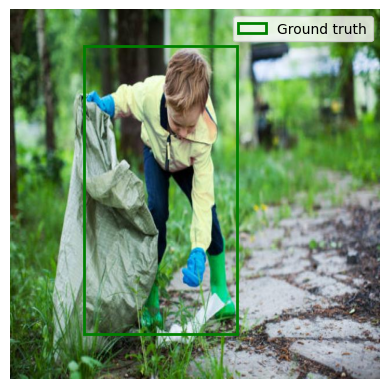

In [55]:
plt.imshow(img_np)
ax = plt.gca()

# Ground‑truth (green)
gt_rect = plt.Rectangle(
    (gt_bbox[0], gt_bbox[1]),
    gt_bbox[2] - gt_bbox[0],
    gt_bbox[3] - gt_bbox[1],
    linewidth=2,
    edgecolor="g",
    facecolor="none",
    label="Ground truth",
)
ax.add_patch(gt_rect)
plt.legend()
plt.axis("off")

In [56]:
with torch.no_grad():
    pred = model([img_model])[0]  # one dict per image

# Take the *most confident* prediction
score, idx = torch.max(pred["scores"], dim=0)
pred_box = pred["boxes"][idx]  # (x1, y1, x2, y2)
pred_label = pred["labels"][idx]  # class id (1‑based in COCO)
pred_score = pred["scores"][idx]

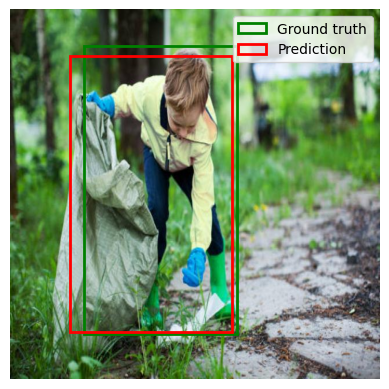

In [57]:
plt.imshow(img_np)
ax = plt.gca()

# Ground‑truth (green)
gt_rect = plt.Rectangle(
    (gt_bbox[0], gt_bbox[1]),
    gt_bbox[2] - gt_bbox[0],
    gt_bbox[3] - gt_bbox[1],
    linewidth=2,
    edgecolor="g",
    facecolor="none",
    label="Ground truth",
)
ax.add_patch(gt_rect)

# Prediction (red)
pred_rect = plt.Rectangle(
    (pred_box[0], pred_box[1]),
    pred_box[2] - pred_box[0],
    pred_box[3] - pred_box[1],
    linewidth=2,
    edgecolor="r",
    facecolor="none",
    label="Prediction",
)
ax.add_patch(pred_rect)

plt.legend()
plt.axis("off")
plt.show()

In [58]:
i = iou(pred_box, gt_bbox).item()
print(f"Pred box:   {pred_box.tolist()}")
print(f"GT  box:    {gt_bbox.tolist()}")
print(f"IoU: {i:.3f}")

# Simple decision rule (e.g. IoU ≥ 0.5 is a true positive)
is_tp = i >= 0.5
print("TP?", is_tp)

Pred box:   [103.3697280883789, 79.3836441040039, 383.4300231933594, 558.2218627929688]
GT  box:    [128.0, 63.0, 392.5, 562.0]
IoU: 0.851
TP? True


<span style="background-color: #FFFF99;">--------------------------------------------------------------------------------------------------------------------------------</span>

# Precision-Recall and ROC Curve Example 

In [59]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)


# Helper to print a formatted confusion matrix
def print_cm(cm):
    print("Confusion matrix:")
    print(
        pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
    )

# Load Cancer Data

In [60]:
X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

## Train Classifier

In [61]:
log_reg = LogisticRegression(max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


## Probabilities for the positive class (malignant)

In [62]:
probs_pos = log_reg.predict_proba(X_test)[:, 1]

##  Default 0.5 Threshold

In [63]:
threshold = 0.5
y_pred_default = (probs_pos >= threshold).astype(int)

## Report

In [64]:
print("=== Default Threshold = 0.5 ===")
print_cm(confusion_matrix(y_test, y_pred_default))
print(f"Precision: {precision_score(y_test, y_pred_default):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_default):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_default, digits=4))

=== Default Threshold = 0.5 ===
Confusion matrix:
          Pred 0  Pred 1
Actual 0      48       5
Actual 1       1      89
Precision: 0.9468
Recall   : 0.9889

Classification Report:
              precision    recall  f1-score   support

           0     0.9796    0.9057    0.9412        53
           1     0.9468    0.9889    0.9674        90

    accuracy                         0.9580       143
   macro avg     0.9632    0.9473    0.9543       143
weighted avg     0.9590    0.9580    0.9577       143



## Compute metrics for all thresholds (including 0.01 to 0.99 step 0.01)

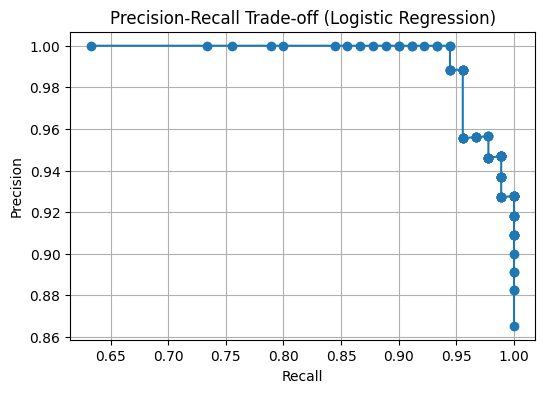

In [65]:
ts = np.linspace(0.01, 0.99, 99)
precisions = []
recalls = []

for t in ts:
    y_pred_t = (probs_pos >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_t))
    recalls.append(recall_score(y_test, y_pred_t))

plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, marker="o")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision‑Recall Trade‑off (Logistic Regression)")
plt.grid(True)
plt.show()

## ROC Curve

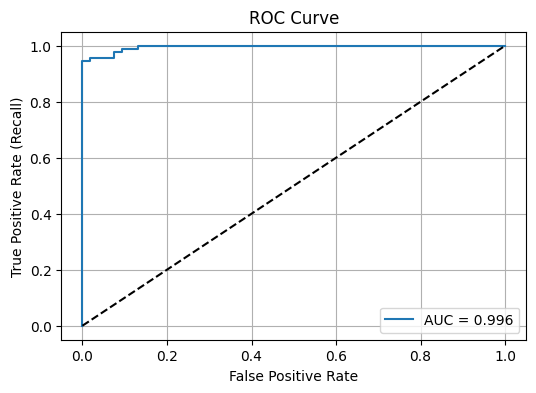

In [66]:
fpr, tpr, _ = roc_curve(y_test, probs_pos)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

<span style="background-color: #FFFF99;">--------------------------------------------------------------------------------------------------------------------------------</span>

# Cross Validation

## Leave-one-out cross-validation

## Sklearn Example

In [67]:
import numpy as np
from sklearn.datasets import load_iris, load_diabetes
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [68]:
# --- Load data -------------------------------------------------------------
X, y = load_iris(return_X_y=True)
X, y = shuffle(X, y, random_state=42)

# --- Model ---------------------------------------------------------------
model = LogisticRegression(max_iter=2000)   # small dataset → no need to tune

# --- LeaveOneOut CV -------------------------------------------------------
loo = LeaveOneOut()
scores = cross_val_score(model, X, y, cv=loo, scoring='accuracy')
print(f"LOO Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# If you want the *individual* predictions for each left‑out sample:
y_pred = cross_val_predict(model, X, y, cv=loo)
print("First 10 predictions:", y_pred[:10])
print("First 10 true labels:", y[:10])

LOO Accuracy: 0.9667 ± 0.1795
First 10 predictions: [1 0 2 1 1 0 1 2 1 1]
First 10 true labels: [1 0 2 1 1 0 1 2 1 1]


## Diabetes Data Example LeaveOneOut Linear Regression 

In [69]:
X, y = load_diabetes(return_X_y=True)
X, y = shuffle(X, y, random_state=42)

model = LinearRegression()

# LOO on regression metrics
mse_scores = cross_val_score(model, X, y, cv=LeaveOneOut(), scoring='neg_mean_squared_error')
mse = -mse_scores.mean()
print(f"LOO RMSE: {np.sqrt(mse):.4f}")


LOO RMSE: 54.7883


## Diabetes Data Example LeaveOneOut Logistic Regression 

In [70]:
X, y = load_diabetes(return_X_y=True)
X, y = shuffle(X, y, random_state=42)

model = LogisticRegression()

# LOO on regression metrics
mse_scores = cross_val_score(model, X, y, cv=LeaveOneOut(), scoring='neg_mean_absolute_error')
mse = -mse_scores.mean()
print(f"LOO RMSE: {np.sqrt(mse):.4f}")


LOO RMSE: 7.5694


## Manual LOO implementation (full control)

In [71]:
def manual_loo_cv(X, y, estimator, scoring=None):
    """
    Simple manual Leave‑One‑Out CV.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
    y : array-like, shape (n_samples,)
    estimator : scikit‑learn estimator with fit/predict
    scoring : callable or string (optional)

    Returns
    -------
    scores : np.ndarray of shape (n_samples,)
    y_pred : np.ndarray of shape (n_samples,)
    """
    n_samples = X.shape[0]
    y_pred = np.empty(n_samples)
    scores = np.empty(n_samples)

    for idx in range(n_samples):
        # Train on all except idx
        X_train = np.delete(X, idx, axis=0)
        y_train = np.delete(y, idx)
        X_test = X[idx].reshape(1, -1)

        # Clone to avoid cross‑fitting
        est = clone(estimator)
        est.fit(X_train, y_train)

        # Predict
        pred = est.predict(X_test)[0]
        y_pred[idx] = pred

        # Score
        if scoring is None:
            scores[idx] = 1.0 if pred == y[idx] else 0.0  # crude accuracy
        else:
            scores[idx] = scoring(y[idx], pred)

    return scores, y_pred

In [72]:
from sklearn.base import clone
from sklearn.metrics import accuracy_score

# Note: we need a callable that returns a score
scoring_func = lambda true, pred: 1.0 if true == pred else 0.0

X, y = load_iris(return_X_y=True)

scores, y_pred = manual_loo_cv(X, y, LogisticRegression(max_iter=2000), scoring=scoring_func)
print(f"Manual LOO Accuracy: {scores.mean():.4f}")

Manual LOO Accuracy: 0.9667


LOO ROC‑AUC: 1.0000


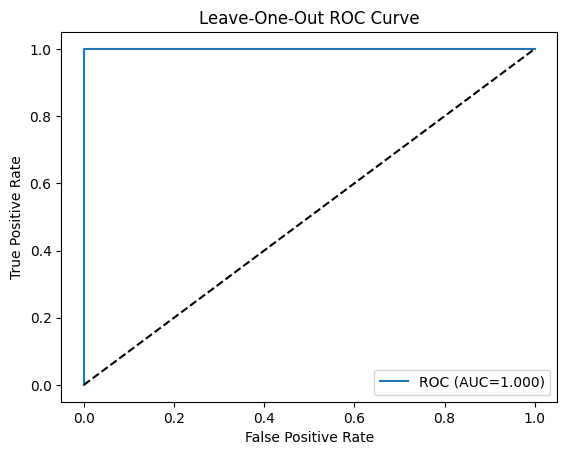

In [73]:
X, y = load_iris(return_X_y=True)
y_bin = (y == 0).astype(int)      # pick class 0 vs. others

model = LogisticRegression(max_iter=2000)
y_prob = cross_val_predict(model, X, y_bin, cv=LeaveOneOut(), method='predict_proba')[:, 1]

auc = roc_auc_score(y_bin, y_prob)
print(f"LOO ROC‑AUC: {auc:.4f}")

# Plot ROC
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_bin, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC={auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Leave‑One‑Out ROC Curve')
plt.legend()
plt.show()

## The simplest hold‑out split

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# --- Load data -----------------------------------------
X, y = load_iris(return_X_y=True)

# --- Split into train / test (hold‑out) ---------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,          # 30 % left for testing
    random_state=42,         # reproducible
    shuffle=True,            # optional – default is True
    stratify=y if len(set(y)) > 2 else None  # keep class balance
)

# --- Train ------------------------------------------------
clf = LogisticRegression(max_iter=2000, solver='lbfgs')
clf.fit(X_train, y_train)

# --- Evaluate ---------------------------------------------
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9333333333333333

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.88      0.93      0.90        15
           2       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



## A scratch version 

In [75]:
import numpy as np

def holdout_cv(X, y, model, n_splits=5, test_size=0.3, random_state=None):
    """Simple repeated‑holdout cross‑validation."""
    rng = np.random.default_rng(random_state)
    scores = []

    for seed in rng.integers(0, 1e9, size=n_splits):
        X_tr, X_te, y_tr, y_te = train_test_split(
            X, y, test_size=test_size, random_state=seed, shuffle=True
        )
        mdl = clone(model)   # avoid side‑effects
        mdl.fit(X_tr, y_tr)
        score = accuracy_score(y_te, mdl.predict(X_te))
        scores.append(score)

    return np.mean(scores), np.std(scores)

# Example
from sklearn.base import clone
mean_acc, std_acc = holdout_cv(X, y, LogisticRegression(max_iter=2000))
print(f"Repeated hold‑out accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

Repeated hold‑out accuracy: 0.9600 ± 0.0166


## A quick “plug‑and‑play” example

In [76]:
import numpy as np
from sklearn.datasets import load_wine
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

X, y = load_wine(return_X_y=True)

kf = KFold(n_splits=5, shuffle=True, random_state=0)

accs = []

for tr, te in kf.split(X):
    model = LogisticRegression(max_iter=20000)
    model.fit(X[tr], y[tr])
    accs.append(accuracy_score(y[te], model.predict(X[te])))

print("5‑fold CV accuracy: {:.4f} ± {:.4f}".format(np.mean(accs), np.std(accs)))

5‑fold CV accuracy: 0.9551 ± 0.0223
